5. Use Tensorflow for automatic differentiation

In [ ]:
#import libraries
import numpy as np
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt

In [ ]:
#parameter initialization
def initialize_parameters(nx,nh,ny):
    #set tensorflow global random seed
    tf.random.set_seed(1)

    #parameters defined as tensorflow variables instead of numpy arrays
    #initialize weights to small random numbers and biases to zeros for each layer. Note that weights and biases are defined as tensorflow variables instead of numpy arrays
    W1=tf.Variable(tf.random.uniform(shape=(nh,nx), minval=-0.01, maxval=0.01), name="W1")
    b1=tf.Variable(tf.zeros(shape=(nh,1),name="b1" ))
    W2=tf.Variable(tf.random.uniform(shape=(ny,nh), minval=-0.01, maxval=0.01), name="W2")
    b2=tf.Variable(tf.zeros(shape=(ny,1), name="b2"))
   
    #create a dictionary of network parameters
    parameters = {"W1": W1,
                  "b1": b1,
                  "W2": W2,
                  "b2": b2}
    
    return parameters

In [ ]:
def forward_pass(parameters,X):
    #the input is read as an integer, use tf.cast to cast it to float before using it in fowrard pass computation.
    X= tf.cast(X, tf.float32)  
    Z1= tf.matmul(parameters["W1"],X)+ parameters["b1"] # b1 is broadcasted n times before it is added to 
    A1=tf.nn.relu(Z1)
    Z2=tf.matmul(parameters["W2"],A1)+parameters["b2"] #b2 is broadcasted n times before it is added to np.dpt(W2,A1)
    
    Yhat = Z2 #remove sigmoid activation since this is a regression problem
       
    return Yhat

In [ ]:
def compute_loss(Y, Yhat):
  per_sample_losses = (Y - Yhat)**2
  loss = tf.reduce_mean(per_sample_losses)
  return loss

In [ ]:
def backward_pass(parameters, loss, tape):
    gradients= tape.gradient(loss,parameters)
    return gradients

In [ ]:
def update_parameters(parameters, gradients, learning_rate):
    parameters["W1"].assign_sub(learning_rate*gradients["W1"])
    parameters["W2"].assign_sub(learning_rate*gradients["W2"])
    parameters["b1"].assign_sub(learning_rate*gradients["b1"])
    parameters["b2"].assign_sub(learning_rate*gradients["b2"])
    return parameters

In [ ]:

def create_nn_model(train_X,train_Y,nh, val_X, val_Y, num_iterations, learning_rate):

    assert(train_X.shape[0]==val_X.shape[0]), "train_X and val_X must have the same number of features"
    assert(train_X.shape[1]==train_Y.size), "train_X and train_Y must have the same number of examples"
    assert(val_X.shape[1]==val_Y.size), "val_X and val_Y must have the same number of examples" 
    
    
    #getting the number of features
    nx=train_X.shape[0]
    
    # We want to use this network for binary classification, so we have only one neuron in the output layer with a sigmoid activation
    ny=1
    
    # initializing the parameteres
    parameters=initialize_parameters(nx,nh,ny)
    
    
    #initialize lists to store the training and valideation losses. 
    val_losses=[]
    train_losses=[]
    
    #run num_iterations of gradient descent
    for i in range (0, num_iterations):
      
      """
        run forward pass and compute the loss function on training and validation data. 
        Note that the forward pass and loss computations on the training data are enclosed inside the gradient tape context in order to build the computational graph.
        The gradients are only computed on the training data and used to update the parameter. Validation data is not used for training and updating the parameters.
        """
      
      with tf.GradientTape() as tape:
        #run the forward pass on train_X
        train_Yhat=forward_pass(parameters,train_X)
        #compute the train_loss
        train_loss=compute_loss(train_Y,train_Yhat)


       #compute validation loss
      Yhat_val= forward_pass(parameters,val_X)
      val_loss=compute_loss(val_Y,Yhat_val)
      
      #print the trianing loss and validation loss for each iteration.
      print("iteration {} :train_loss:{} val_loss{}".format(i,train_loss,val_loss))

       # append the train and validation loss for the current iteration to the train_losses and val_losses 
      train_losses.append(train_loss)
      val_losses.append(val_loss)
     
      """
      Compute the gradients and update the parameters
      """    
      #compute the gradients on the training data
      gradients=backward_pass(parameters,train_loss,tape)

      # update the parameters
      parameters=update_parameters(parameters, gradients, learning_rate)

    
    
    #create a dictionary history and put train_loss and validaiton_loss in it
    history={"val_loss": val_losses,
             "train_loss": train_losses}
        
        
    #return the parameters and the history
    return parameters, history
        

In [ ]:
#get predictions
def predict(parameters,X):
    Yhat=forward_pass(parameters, X)
    return Yhat

In [ ]:
#define a function to calculate the MAPE
def MAPE(observedY, predictedY):
    per_sample_loss = abs(observedY - predictedY)/observedY
    mape = tf.reduce_mean(per_sample_loss)
    return float(mape)

In [ ]:
#load the data
df = pd.read_csv("sample_data/california_housing_train.csv")

In [ ]:
#split training data into 80% training and 20% validation
train = df.sample(frac=0.8, random_state=123)
val = df.drop(train.index)

In [ ]:
# reading the input datasets train.csv and validation.csv and store them into numpy arrays
train = train.to_numpy()
test = pd.read_csv('sample_data/california_housing_test.csv').to_numpy()
val = val.to_numpy()

In [ ]:
#separate the features from the target variable (median_house_value) in train, val and test
train_X = train[:,:-1]
train_Y = train[...,-1] #labels

test_X = test[:,:-1]
test_Y = test[...,-1] #labels

val_X = val[:,:-1]
val_Y = val[...,-1] #labels

In [ ]:
print(train_X.shape)
print(test_X.shape)
print(val_X.shape)
print(train_Y.shape)
print(test_Y.shape)
print(val_Y.shape)
print(test_Y)

(13600, 8)
(3000, 8)
(3400, 8)
(13600,)
(3000,)
(3400,)
[344700. 176500. 270500. ...  62000. 162500. 500001.]


In [ ]:
#normalize the data: subtract mean of each feature and divide by the std, so that the feature is centered around 0 and has a unit std
train_norm = (train_X - np.mean(train_X, axis=0))/np.std(train_X, axis=0)
test_norm = (test_X - np.mean(train_X, axis=0))/np.std(train_X, axis=0)
val_norm = (val_X - np.mean(train_X, axis=0))/np.std(train_X, axis=0)

print(train_norm.shape)
print(test_norm.shape)
print(val_norm.shape)

(13600, 8)
(3000, 8)
(3400, 8)


In [ ]:
#divide the median_house_values by 100k to scale them down
train_Y = train_Y/100000
test_Y = test_Y/100000
val_Y = val_Y/100000

In [ ]:
#transpose feature matricies for train,test,val and reshape target vectors to 2D arrays
train_norm = train_norm.transpose()
test_norm = test_norm.transpose()
val_norm = val_norm.transpose()

In [ ]:
train_Y=np.reshape(train_Y, (1, train_Y.size))
test_Y=np.reshape(test_Y, (1, test_Y.size))
val_Y=np.reshape(val_Y, (1, val_Y.size))

In [ ]:
print(train_norm.shape)
print(train_Y.shape)
print(val_norm.shape)
print(val_Y.shape)
print(test_norm.shape)
print(test_Y.shape)

(8, 13600)
(1, 13600)
(8, 3400)
(1, 3400)
(8, 3000)
(1, 3000)


In [ ]:
iterations= 2000
parameters, history=create_nn_model(train_norm,train_Y,128, val_norm, val_Y, iterations, 0.001)

iteration 0 :train_loss:5.630237102508545 val_loss5.691183567047119
iteration 1 :train_loss:5.61295747756958 val_loss5.673861503601074
iteration 2 :train_loss:5.595747470855713 val_loss5.656608581542969
iteration 3 :train_loss:5.578606605529785 val_loss5.639425754547119
iteration 4 :train_loss:5.561534881591797 val_loss5.622311115264893
iteration 5 :train_loss:5.544531345367432 val_loss5.6052656173706055
iteration 6 :train_loss:5.527596473693848 val_loss5.588288307189941
iteration 7 :train_loss:5.51072883605957 val_loss5.571379661560059
iteration 8 :train_loss:5.493929862976074 val_loss5.554538249969482
iteration 9 :train_loss:5.477199077606201 val_loss5.5377655029296875
iteration 10 :train_loss:5.46053409576416 val_loss5.521059513092041
iteration 11 :train_loss:5.443937301635742 val_loss5.504420280456543
iteration 12 :train_loss:5.427405834197998 val_loss5.487848281860352
iteration 13 :train_loss:5.410942077636719 val_loss5.47134256362915
iteration 14 :train_loss:5.3945441246032715 va

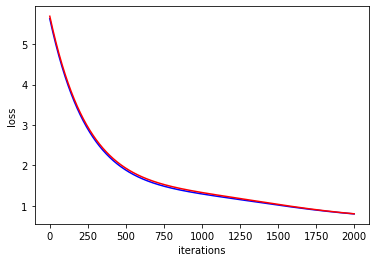

In [ ]:
plt.plot(range(0,iterations),history["train_loss"],'b')
plt.plot(range(0,iterations),history["val_loss"],'r')
plt.ylabel('loss')
plt.xlabel('iterations')
plt.show()

In [ ]:
predicted_test = predict(parameters, test_norm)
TF_MAPE = MAPE(test_Y, predicted_test)
print("The MAPE of the Tensorflow model is: ", TF_MAPE)

The MAPE of the Tensorflow model is:  0.49584582448005676
